# Macroeconometrics Project

Replication and extension study for the discussion paper 'An empirical assessment of the U.S. Phillips curve over time' by Marente Vlekke, Siem Jan Koopman and Martin Mellens.

In [1]:
import arviz as az
import jax
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import plotnine as p9
import statsmodels.api as sm

from pandas_datareader import fred
from scipy import stats, optimize
from statsmodels.base.model import GenericLikelihoodModel

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
jax.config.update('jax_platform_name', 'cpu')
numpyro.set_host_device_count(8)

In [3]:
seed = sum(map(ord, 'Macroeconometrics project, Vlekke, Kooman and Mellens replication'))
rng = np.random.default_rng(seed)

## Data

In [4]:
import datetime
import requests_cache

session = requests_cache.CachedSession(cache_name='fred', backend='sqlite', expire_after=datetime.timedelta(days=1))

fred_symbols = [
    # Inflation
    'CPIAUCSL', # Consumer Price Index for All Urban Consumers: All Items in U.S. City Average, Index 1982-1984=100, Seasonally Adjusted, Monthly
    'CPILFESL', #  Consumer Price Index for All Urban Consumers: All Items Less Food and Energy in U.S. City Average, Index 1982-1984=100, Seasonally Adjusted, Monthly
    'PCEPI', # Personal Consumption Expenditures: Chain-type Price Index, Index 2017=100, Seasonally Adjusted, Monthly
    'PCEPILFE', # Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index), Index 2017=100, Seasonally Adjusted, Monthly
    # Unemployment
    'UNRATE', # Unemployment Rate, Percent, Seasonally Adjusted, Monthly
    'NROU', # Noncyclical Rate of Unemployment, Percent, Not Seasonally Adjusted, Quarterly
    # GDP
    'GDP', # Gross Domestic Product, Billions of Dollars, Seasonally Adjusted Annual Rate, Quarterly
    'NGDPPOT', # Nominal Potential Gross Domestic Product, Billions of Dollars, Not Seasonally Adjusted, Quarterly
    'GDPPOT', # Real Potential Gross Domestic Product, Billions of Chained 2017 Dollars, Not Seasonally Adjusted, Quarterly
    # Supply shock control variables
    'A021RD3Q086SBEA', # Imports of goods and services (implicit price deflator), Index 2017=100, Seasonally Adjusted, Quarterly
    'GDPDEF', # Gross Domestic Product: Implicit Price Deflator, Index 2017=100, Seasonally Adjusted, Quarterly
    'WTISPLC', # Spot Crude Oil Price: West Texas Intermediate (WTI), Dollars per Barrel, Not Seasonally Adjusted, Monthly
    # Interest rate
    'FEDFUNDS', # Federal Funds Effective Rate, Percent, Not Seasonally Adjusted, Monthly
    # Inflation expectations
    'MICH', # University of Michigan: Inflation Expectation, Percent, Not Seasonally Adjusted, Monthly
]

fred_raw = fred.FredReader(symbols=fred_symbols, start=1900, end=2025, session=session).read()

In [128]:
# Resample data as quarterly data, take the last observation during that period
fred_df = fred_raw.resample('QS').last()

# Limit data to before 2025
fred_df = fred_df[fred_df.index < '2025-01-01']

# Calculate annualized quarter-on-quarter inflation changes
fred_df['cpi_aqoq'] = ((1 + fred_df['CPIAUCSL'].pct_change()) ** 4 - 1) * 100
fred_df['cpix_aqoq'] = ((1 + fred_df['CPILFESL'].pct_change()) ** 4 - 1) * 100
fred_df['pce_aqoq'] = ((1 + fred_df['PCEPI'].pct_change()) ** 4 - 1) * 100
fred_df['pcex_aqoq'] = ((1 + fred_df['PCEPILFE'].pct_change()) ** 4 - 1) * 100

# Unemployment
fred_df['u'] = fred_df['UNRATE']
fred_df['u_n'] = fred_df['NROU']
fred_df['u_gap'] = fred_df['u'] - fred_df['u_n']

# Supply shock control variables
fred_df['imp'] = fred_df['A021RD3Q086SBEA']
fred_df['gdp_def'] = fred_df['GDPDEF']
fred_df['rel_imp_p_idx'] = fred_df['imp'] / fred_df['gdp_def']
fred_df['rel_imp_p_aqoq'] = ((1 + fred_df['rel_imp_p_idx'].pct_change(fill_method=None)) ** 4 - 1) * 100
fred_df['oil_p_aqoq'] = ((1 + fred_df['WTISPLC'].pct_change()) ** 4 - 1) * 100

# Interest rates
fred_df['i'] = fred_df['FEDFUNDS']

# Cosnumer inflation expectations
fred_df['e_h_cpi_1'] = fred_df['MICH']

# Backwards-looking expectations
fred_df['e_b_cpi'] = fred_df['cpi_aqoq'].rolling(window=4).mean().shift(1)
fred_df['e_b_cpix'] = fred_df['cpix_aqoq'].rolling(window=4).mean().shift(1)
fred_df['e_b_pce'] = fred_df['pce_aqoq'].rolling(window=4).mean().shift(1)
fred_df['e_b_pcex'] = fred_df['pcex_aqoq'].rolling(window=4).mean().shift(1)

fred_df = fred_df[['cpi_aqoq', 'cpix_aqoq', 'pce_aqoq', 'pcex_aqoq', 'u', 'u_n', 'u_gap', 'imp', 'gdp_def', 'rel_imp_p_idx', 'rel_imp_p_aqoq', 'oil_p_aqoq', 'i', 'e_h_cpi_1', 'e_b_cpi', 'e_b_cpix', 'e_b_pce', 'e_b_pcex']]

In [129]:
fred_df.tail()

cpi_aqoq  cpix_aqoq  pce_aqoq  pcex_aqoq    u       u_n     u_gap  \
DATE                                                                            
2023-10-01  1.906163   3.343949  0.710362   1.636068  3.8  4.419751 -0.619751   
2024-01-01  4.596141   4.530819  4.379274   4.388082  3.9  4.416962 -0.516962   
2024-04-01  1.053362   2.097782  1.495558   2.254738  4.1  4.414191 -0.314191   
2024-07-01  2.108149   3.076850  1.860962   2.384926  4.1  4.411415 -0.311415   
2024-10-01  2.249526   2.377763  1.437419   1.517888  4.1  4.408619 -0.308619   

                imp  gdp_def  rel_imp_p_idx  rel_imp_p_aqoq  oil_p_aqoq     i  \
DATE                                                                            
2023-10-01  111.058  123.241       0.901145       -1.537027  -58.218634  5.33   
2024-01-01  111.786  124.163       0.900317       -0.367200   63.312421  5.33   
2024-04-01  112.372  124.943       0.899386       -0.412725   -7.226575  5.33   
2024-07-01  112.314  125.532       0.894704       -2.066097  -39.885444  5.13   
2024-10-01      NaN      NaN            NaN             NaN   -0.681622  4.48   

            e_h_cpi_1   e_b_cpi  e_b_cpix   e_b_pce  e_b_pcex  
DATE                                                           
2023-10-01        3.1  3.695399  4.145765  3.416978  3.660718  
2024-01-01        2.9  3.327616  3.912671  2.708934  3.042222  
2024-04-01        3.0  3.480896  3.798862  2.818251  2.985381  
2024-07-01        2.7  2.987139  3.280547  2.446188  2.635745  
2024-10-01        2.6  2.415954  3.262350  2.111539  2.665953

In [130]:
spf_files = [
    'Median_CPI_Level.xlsx',
    'Median_CPI5YR_Level.xlsx',
    'Median_CPI10_Level.xlsx',
    'Median_CORECPI_Level.xlsx',
    'Median_COREPCE_Level.xlsx',
    'Median_PCE_Level.xlsx',
    'Median_PCE5YR_Level.xlsx',
    'Median_PCE10_Level.xlsx',
]

spf_raw = pd.concat([pd.read_excel(f'data/{spf_file}').set_index(['YEAR', 'QUARTER']) for spf_file in spf_files], axis=1)
spf_raw.columns

/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it wi

Index(['CPI1', 'CPI2', 'CPI3', 'CPI4', 'CPI5', 'CPI6', 'CPIA', 'CPIB', 'CPIC',
       'CPI5YR', 'CPI10', 'CORECPI1', 'CORECPI2', 'CORECPI3', 'CORECPI4',
       'CORECPI5', 'CORECPI6', 'CORECPIA', 'CORECPIB', 'CORECPIC', 'COREPCE1',
       'COREPCE2', 'COREPCE3', 'COREPCE4', 'COREPCE5', 'COREPCE6', 'COREPCEA',
       'COREPCEB', 'COREPCEC', 'PCE1', 'PCE2', 'PCE3', 'PCE4', 'PCE5', 'PCE6',
       'PCEA', 'PCEB', 'PCEC', 'PCE5YR', 'PCE10'],
      dtype='object')

In [131]:
spf_df = spf_raw[['CPIA', 'CPI10', 'CORECPIA', 'PCEA', 'PCE10', 'COREPCEA']]
spf_df = spf_df.rename(columns={
    'CPIA': 'e_p_cpi_1',
    'CPI10': 'e_p_cpi_10',
    'CORECPIA': 'e_p_cpix_1',
    'PCEA': 'e_p_pce_1',
    'PCE10': 'e_p_pce_10',
    'COREPCEA': 'e_p_pcex_1',
})
spf_df = spf_df.reset_index()
spf_df['DATE'] = spf_df['YEAR'].astype(str) + '-Q' + spf_df['QUARTER'].astype(str)
spf_df['DATE'] = pd.PeriodIndex(spf_df['DATE'], freq='Q').to_timestamp()
spf_df = spf_df.drop(columns=['YEAR', 'QUARTER']).set_index('DATE')

In [132]:
spf_df.tail()

e_p_cpi_1  e_p_cpi_10  e_p_cpix_1  e_p_pce_1  e_p_pce_10  \
DATE                                                                   
2023-10-01     3.3373       2.400      3.8922     3.1115        2.22   
2024-01-01     2.4905       2.240      2.6873     2.0948        2.00   
2024-04-01     3.1235       2.325      3.4000     2.7742        2.10   
2024-07-01     2.8471       2.300      3.1534     2.5511        2.10   
2024-10-01     2.5127       2.225      3.1000     2.3651        2.10   

            e_p_pcex_1  
DATE                    
2023-10-01      3.4625  
2024-01-01      2.1170  
2024-04-01      2.9094  
2024-07-01      2.8053  
2024-10-01      2.7375

In [133]:
df = fred_df.join(spf_df, how='outer')
df.index.freq = pd.tseries.frequencies.to_offset('QS')

# Inflation and expected inflation minus backwards-looking inflation expectations
df['cpi_meb'] = df['cpi_aqoq'] - df['e_b_cpi']
df['cpix_meb'] = df['cpix_aqoq'] - df['e_b_cpix']
df['pce_meb'] = df['pce_aqoq'] - df['e_b_pce']
df['pcex_meb'] = df['pcex_aqoq'] - df['e_b_pcex']

df['e_p_cpi_1_meb'] = df['e_p_cpi_1'] - df['e_b_cpi']
df['e_p_cpi_10_meb'] = df['e_p_cpi_10'] - df['e_b_cpi']
df['e_p_cpix_1_meb'] = df['e_p_cpix_1'] - df['e_b_cpix']
df['e_p_pce_1_meb'] = df['e_p_pce_1'] - df['e_b_pce']
df['e_p_pce_10_meb'] = df['e_p_pce_10'] - df['e_b_pce']
df['e_p_pcex_1_meb'] = df['e_p_pcex_1'] - df['e_b_pcex']

df['e_h_cpi_1_meb'] = df['e_h_cpi_1'] - df['e_b_cpi']

df.tail()

cpi_aqoq  cpix_aqoq  pce_aqoq  pcex_aqoq    u       u_n     u_gap  \
DATE                                                                            
2023-10-01  1.906163   3.343949  0.710362   1.636068  3.8  4.419751 -0.619751   
2024-01-01  4.596141   4.530819  4.379274   4.388082  3.9  4.416962 -0.516962   
2024-04-01  1.053362   2.097782  1.495558   2.254738  4.1  4.414191 -0.314191   
2024-07-01  2.108149   3.076850  1.860962   2.384926  4.1  4.411415 -0.311415   
2024-10-01  2.249526   2.377763  1.437419   1.517888  4.1  4.408619 -0.308619   

                imp  gdp_def  rel_imp_p_idx  ...  cpix_meb   pce_meb  \
DATE                                         ...                       
2023-10-01  111.058  123.241       0.901145  ... -0.801816 -2.706616   
2024-01-01  111.786  124.163       0.900317  ...  0.618148  1.670339   
2024-04-01  112.372  124.943       0.899386  ... -1.701081 -1.322693   
2024-07-01  112.314  125.532       0.894704  ... -0.203697 -0.585227   
2024-10-01      NaN      NaN            NaN  ... -0.884587 -0.674120   

            pcex_meb  e_p_cpi_1_meb  e_p_cpi_10_meb  e_p_cpix_1_meb  \
DATE                                                                  
2023-10-01 -2.024651      -0.358099       -1.295399       -0.253565   
2024-01-01  1.345860      -0.837116       -1.087616       -1.225371   
2024-04-01 -0.730643      -0.357396       -1.155896       -0.398862   
2024-07-01 -0.250819      -0.140039       -0.687139       -0.127147   
2024-10-01 -1.148066       0.096746       -0.190954       -0.162350   

            e_p_pce_1_meb  e_p_pce_10_meb  e_p_pcex_1_meb  e_h_cpi_1_meb  
DATE                                                                      
2023-10-01      -0.305478       -1.196978       -0.198218      -0.595399  
2024-01-01      -0.614134       -0.708934       -0.925222      -0.427616  
2024-04-01      -0.044051       -0.718251       -0.075981      -0.480896  
2024-07-01       0.104912       -0.346188        0.169555      -0.287139  
2024-10-01       0.253561       -0.011539        0.071547       0.184046  

[5 rows x 35 columns]

### Inflation

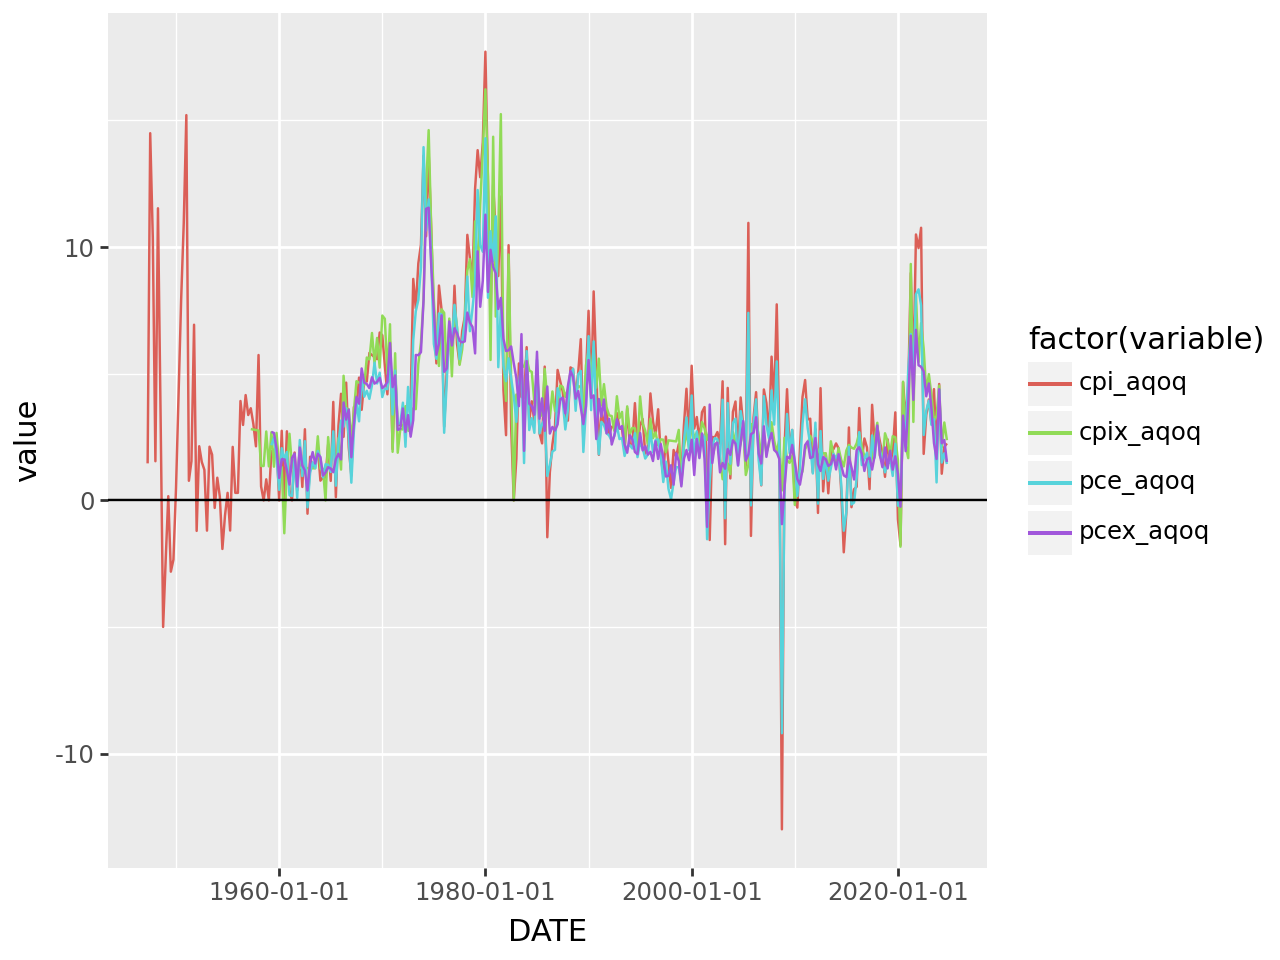

In [134]:
cpi_df_long = pd.melt(df.reset_index(), id_vars=['DATE'], value_vars=['cpi_aqoq', 'cpix_aqoq', 'pce_aqoq', 'pcex_aqoq']).dropna()

(
    p9.ggplot(cpi_df_long, p9.aes('DATE', 'value', color='factor(variable)'))
    + p9.geom_line()
    + p9.geom_hline(yintercept=0)
)

### Inflation expectations

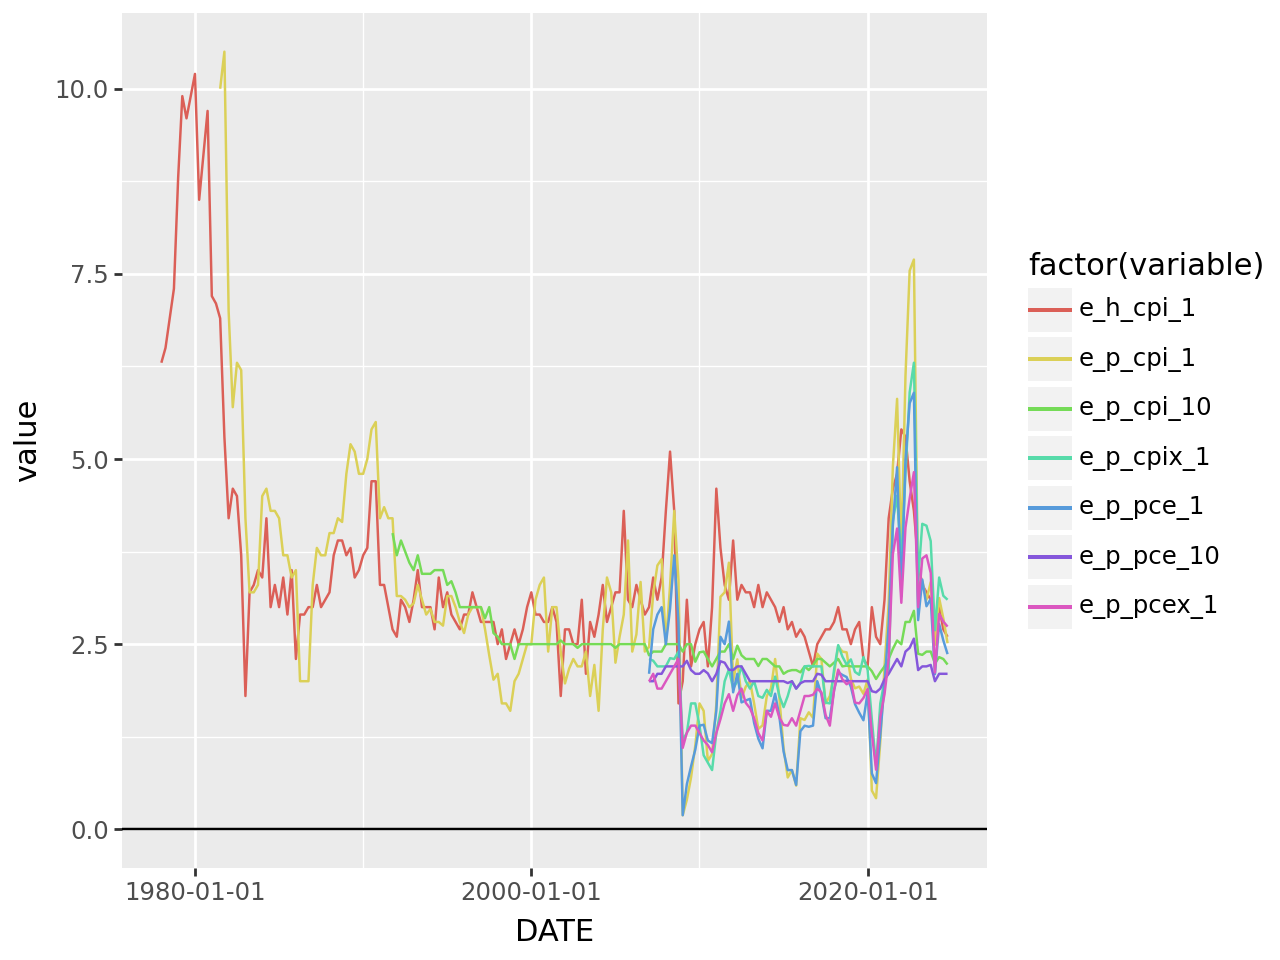

In [135]:
e_cpi_df_long = pd.melt(df.reset_index(), id_vars=['DATE'], value_vars=['e_h_cpi_1', 'e_p_cpi_1', 'e_p_cpi_10', 'e_p_cpix_1', 'e_p_pce_1', 'e_p_pce_10', 'e_p_pcex_1']).dropna()

(
    p9.ggplot(e_cpi_df_long, p9.aes('DATE', 'value', color='factor(variable)'))
    + p9.geom_line()
    + p9.geom_hline(yintercept=0)
)

### Unemployment

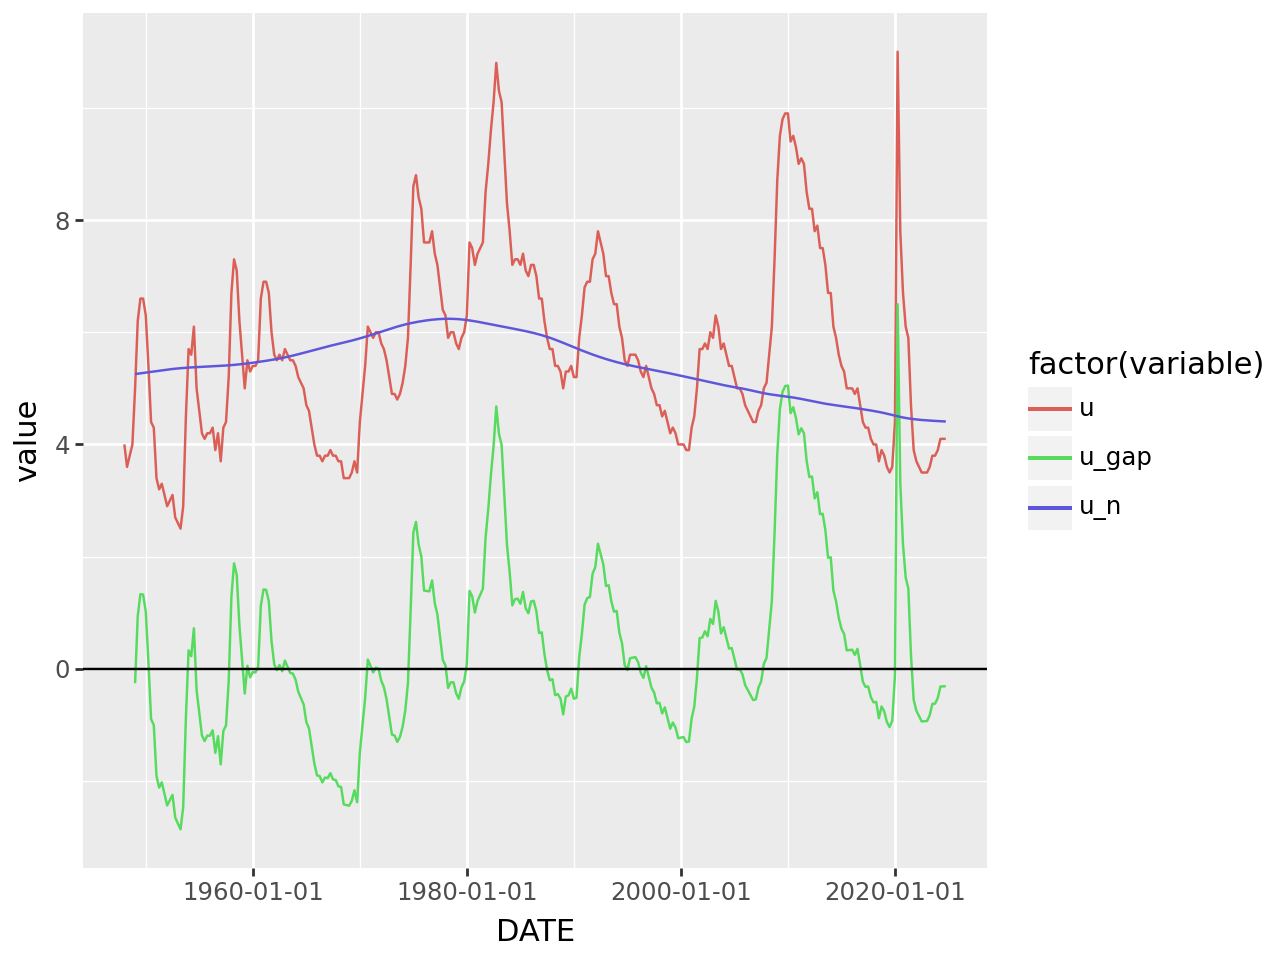

In [136]:
u_df_long = pd.melt(df.reset_index(), id_vars=['DATE'], value_vars=['u', 'u_n', 'u_gap']).dropna()

(
    p9.ggplot(u_df_long, p9.aes('DATE', 'value', color='factor(variable)'))
    + p9.geom_line()
    + p9.geom_hline(yintercept=0)
)

### Supply shocks

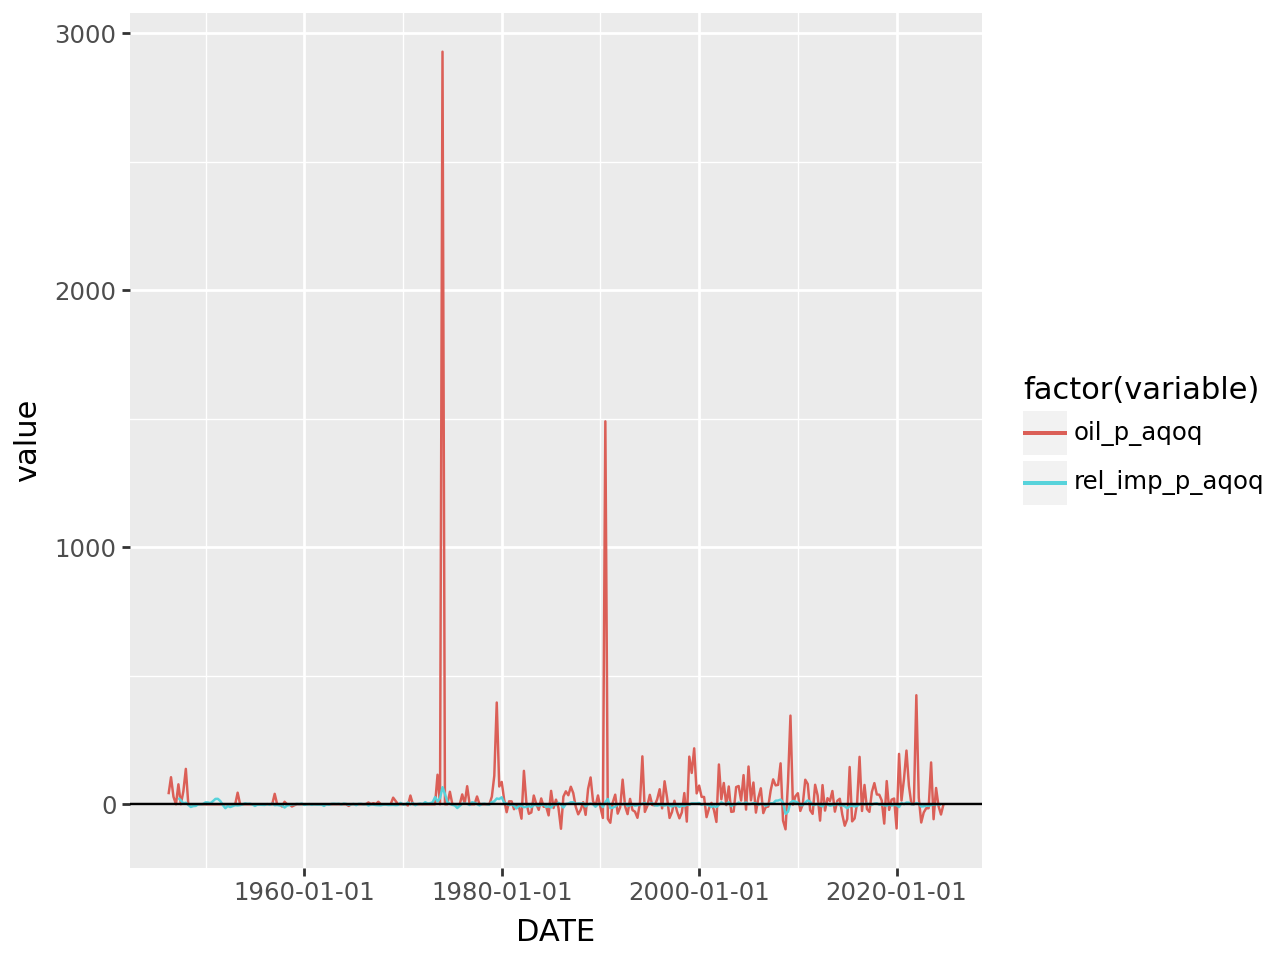

In [137]:
ip_df_long = pd.melt(df.reset_index(), id_vars=['DATE'], value_vars=['rel_imp_p_aqoq', 'oil_p_aqoq']).dropna()

(
    p9.ggplot(ip_df_long, p9.aes('DATE', 'value', color='factor(variable)'))
    + p9.geom_line()
    + p9.geom_hline(yintercept=0)
)

### Select Model Variables

In [138]:
model_df = df[['cpi_aqoq', 'cpi_meb', 'u', 'u_n', 'u_gap', 'e_p_cpi_1', 'e_p_cpi_1_meb', 'e_h_cpi_1', 'e_h_cpi_1_meb', 'rel_imp_p_aqoq', 'oil_p_aqoq', 'e_b_cpi']].dropna()
model2016_df = model_df.loc[model_df.index < '2016-01-01',:]

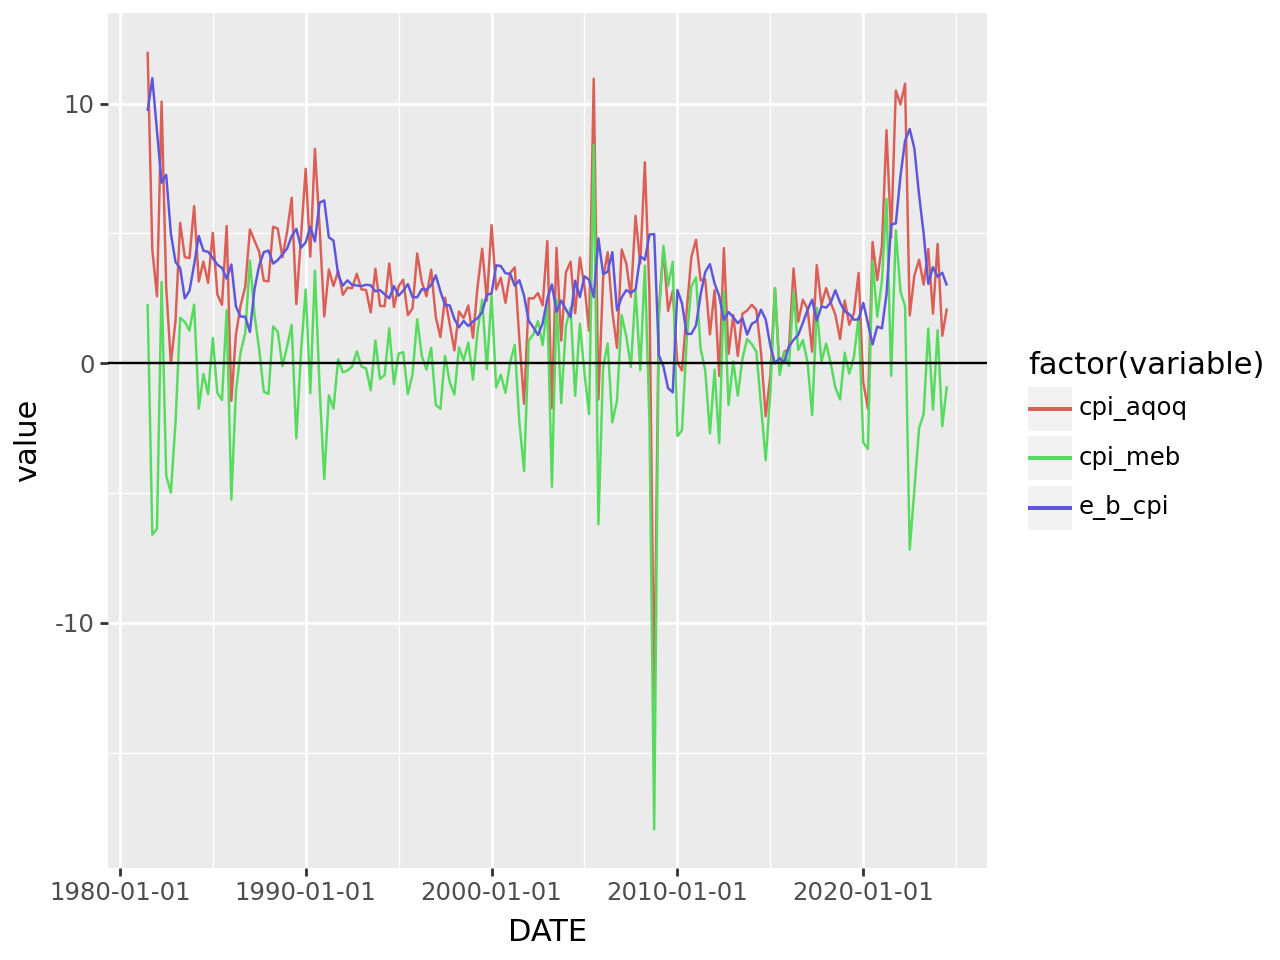

In [139]:
cpi_df_long = pd.melt(model_df.reset_index(), id_vars=['DATE'], value_vars=['cpi_aqoq', 'cpi_meb', 'e_b_cpi']).dropna()

(
    p9.ggplot(cpi_df_long, p9.aes('DATE', 'value', color='factor(variable)'))
    + p9.geom_line()
    + p9.geom_hline(yintercept=0)
)

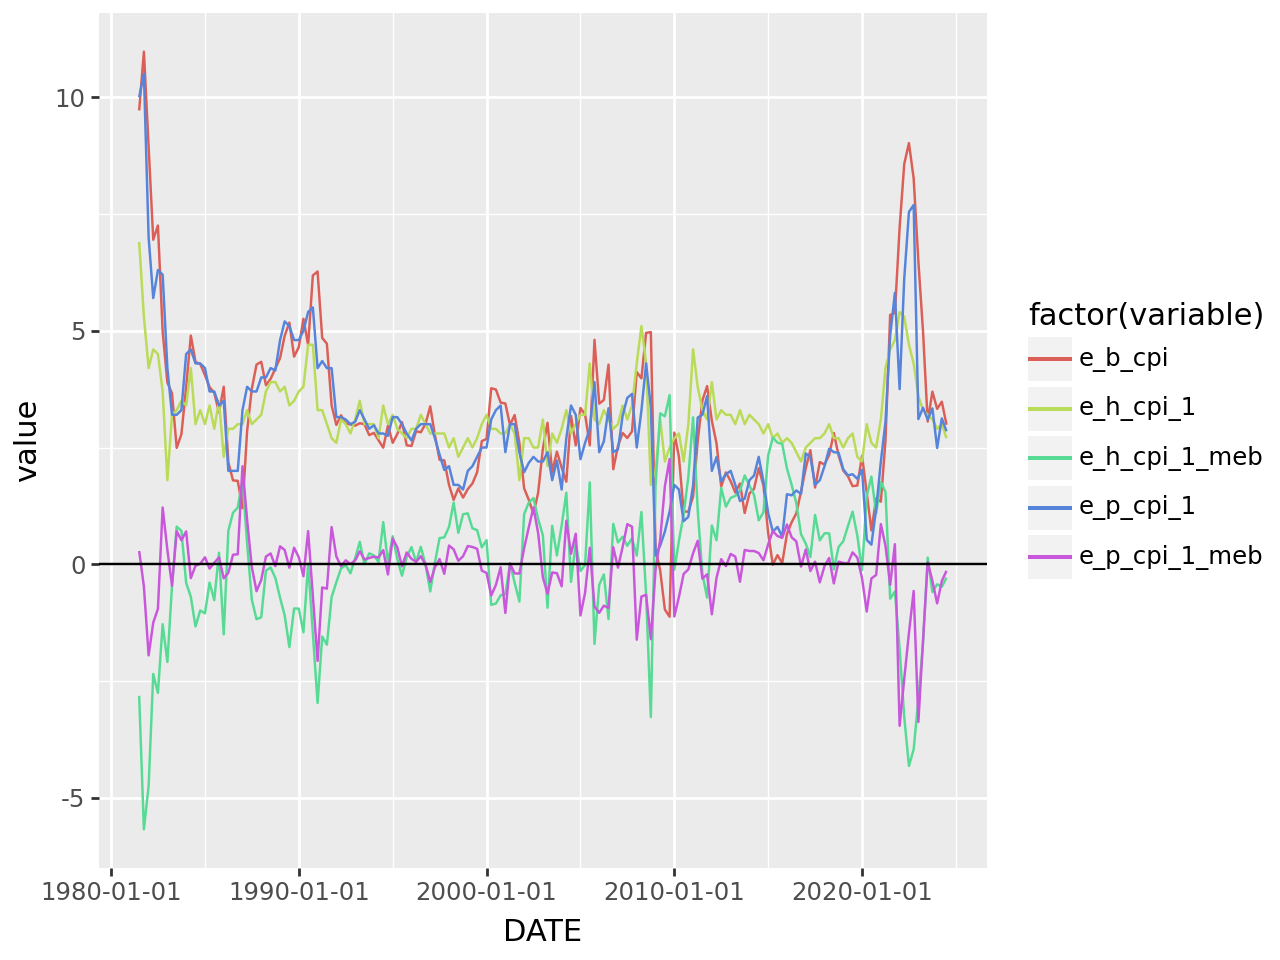

In [140]:
e_cpi_df_long = pd.melt(model_df.reset_index(), id_vars=['DATE'], value_vars=['e_p_cpi_1', 'e_p_cpi_1_meb', 'e_h_cpi_1', 'e_h_cpi_1_meb', 'e_b_cpi']).dropna()

(
    p9.ggplot(e_cpi_df_long, p9.aes('DATE', 'value', color='factor(variable)'))
    + p9.geom_line()
    + p9.geom_hline(yintercept=0)
)

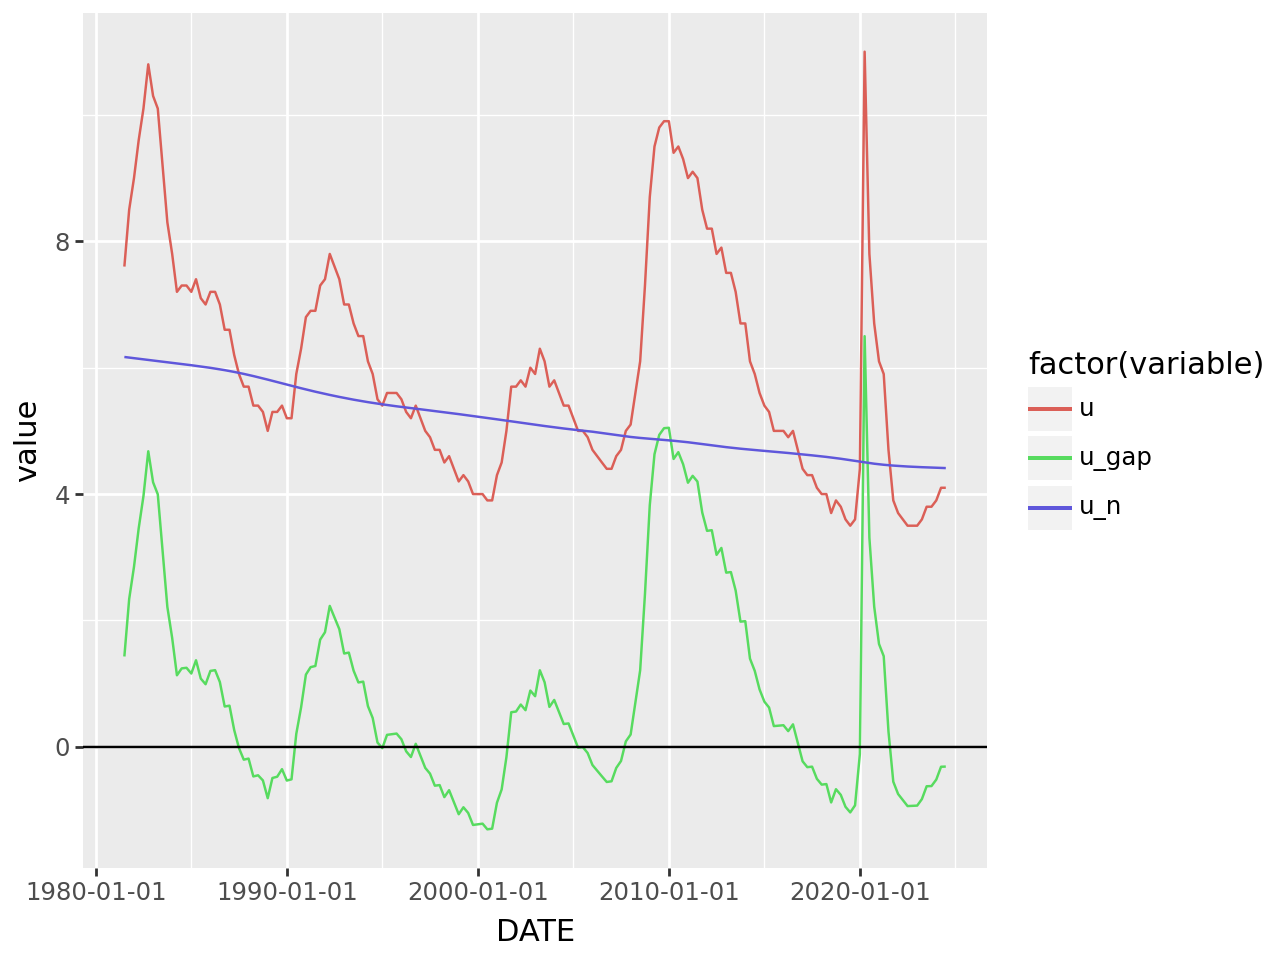

In [141]:
u_df_long = pd.melt(model_df.reset_index(), id_vars=['DATE'], value_vars=['u', 'u_n', 'u_gap']).dropna()

(
    p9.ggplot(u_df_long, p9.aes('DATE', 'value', color='factor(variable)'))
    + p9.geom_line()
    + p9.geom_hline(yintercept=0)
)

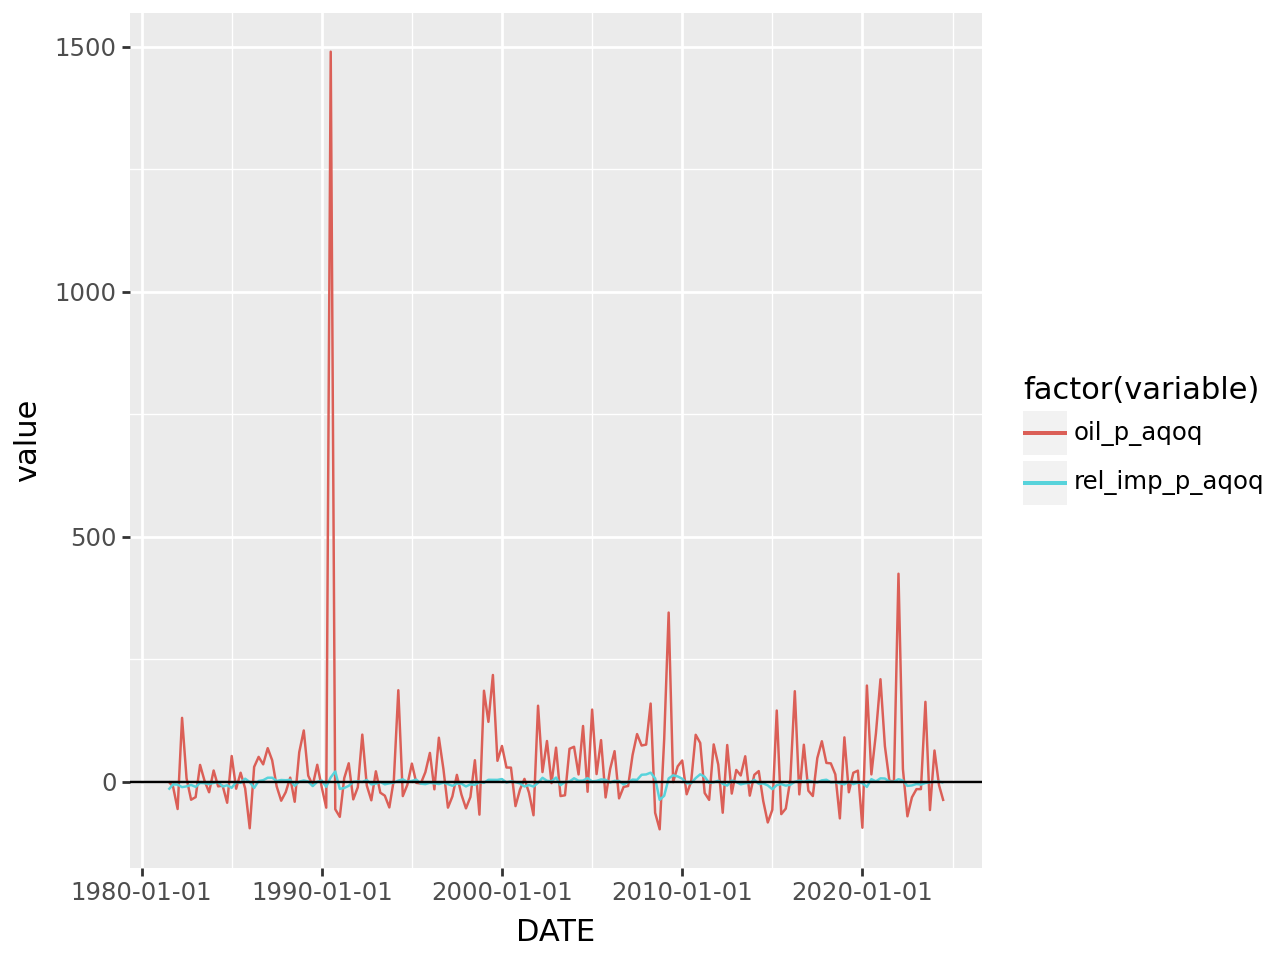

In [142]:
ip_df_long = pd.melt(model_df.reset_index(), id_vars=['DATE'], value_vars=['rel_imp_p_aqoq', 'oil_p_aqoq']).dropna()

(
    p9.ggplot(ip_df_long, p9.aes('DATE', 'value', color='factor(variable)'))
    + p9.geom_line()
    + p9.geom_hline(yintercept=0)
)

## Model

The state space model is specified in the original paper in appendix A.

In [20]:
from pymc.model import modelcontext

from pymc_extras.statespace.utils.constants import (
    ALL_STATE_DIM,
    ALL_STATE_AUX_DIM,
    OBS_STATE_DIM,
    SHOCK_DIM,
    TIME_DIM,
)
from pymc_extras.statespace.core.statespace import PyMCStateSpace
from pymc_extras.statespace.models.utilities import make_default_coords

class VlekkeKoopmanMellens2021(PyMCStateSpace):
    def __init__(self):
        k_states = 5 # size of the state vector x
        k_posdef = 5 # number of shocks (size of the state covariance matrix Q)
        k_endog = 1  # number of observed states

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef)

    def make_symbolic_graph(self):
        exog_data = self.make_and_register_data("exog_data", shape=(None, self.k_states))
        x0 = self.make_and_register_variable('x0', shape=(self.k_states,))
        P0 = self.make_and_register_variable('P0', shape=(self.k_states, self.k_states))
        sigma_sq_eps = self.make_and_register_variable('sigma_sq_eps', shape=())
        sigma_sq_eta = self.make_and_register_variable('sigma_sq_eta', shape=(self.k_posdef,))

        self.ssm['transition', :, :] = np.eye(self.k_states)
        assert self.k_states == self.k_posdef
        self.ssm['selection', :, :] = np.eye(self.k_states, self.k_posdef)

        self.ssm['initial_state', :] = x0
        self.ssm['initial_state_cov', :, :] = P0
        self.ssm["design"] = pt.expand_dims(exog_data, 1)  
        self.ssm['obs_cov', *np.diag_indices(self.k_endog)] = sigma_sq_eps
        self.ssm['state_cov', *np.diag_indices(self.k_posdef)] = sigma_sq_eta

    @property
    def param_names(self):
        return ['x0', 'P0', 'sigma_sq_eps', 'sigma_sq_eta']

    @property
    def state_names(self):
        return ['beta', 'theta', 'phi', 'gamma_1', 'gamma_2']

    @property
    def shock_names(self):
        return [f'{state}_shock' for state in self.state_names]

    @property
    def observed_states(self):
        return ['pi']

    @property
    def param_dims(self):
        return {
            'x0': (ALL_STATE_DIM,),
            'P0': (ALL_STATE_DIM, ALL_STATE_AUX_DIM),
            'sigma_sq_eps': (OBS_STATE_DIM,),
            'sigma_sq_eta': (SHOCK_DIM,),
        }

    @property
    def coords(self):
        coords = make_default_coords(self)
        coords.update({'exog_data_dim': ['u_gap', 'pi_p', 'pi_h', 'rel_i_p', 'oil_p_aqoq']})

        return coords

    @property
    def param_info(self):
        info = {
            'x0': {
                'shape': (self.k_states,),
                'constraints': 'None',
            },
            'P0': {
                'shape': (self.k_states, self.k_states),
                'constraints': 'Positive Semi-definite',
            },
            'sigma_sq_eps': {
                'shape': (self.k_endog,),
                'constraints': 'Positive',
            },
            'sigma_sq_eta': {
                'shape': (self.k_posdef,),
                'constraints': 'Positive',
            },
        }

        for name in self.param_names:
            info[name]['dims'] = self.param_dims[name]

        return info

    @property
    def data_names(self):
        return ['exog_data']
    
    @property
    def data_info(self):
        return {
            'exog_data': {
                'shape': (None, self.k_states),
                'dims': (TIME_DIM, 'exog_data_dim')
            }
        }

### Model Priors

Get priors for the initial state ($b_{40} = [\beta_t, \theta_t, \theta_t, \gamma_t, \gamma_t]$, $P_{40}$) as described in section 2.2 of the reference paper. We estimate equation (7) with maximum likelihood:
$$\pi_t = \beta_t (u_t - u_t^*) + \theta_t \pi_t^{e,P} + (1-\theta_t) \pi_t^{e,B} + \gamma_t \pi_t^M + \varepsilon_t \tag{7}$$
$$\pi_t^{e,B} = \frac{1}{4} \sum_{i=1}^4 \pi_{t-i}$$
$$\implies \pi_t - \pi_t^{e,B} = \beta_t (u_t - u_t^*) + \theta_t (\pi_t^{e,P} - \pi_t^{e,B}) + \gamma_t \pi_t^M + \varepsilon_t$$

In [21]:
import statsmodels.api as sm

# Take first 40 observations
prior_df = model_df.head(40)

y = prior_df[['cpi_meb']]
X = sm.add_constant(prior_df[['u_gap', 'e_p_cpi_1_meb', 'rel_imp_p_aqoq']])

results = sm.OLS(y, X).fit()
print(results.summary())

# Map the found priors to the model parameters
idx_map = [1, 2, 2, 3, 3]
b_40 = np.take(results.params.values, idx_map)
P_40 = np.zeros((5, 5))

for i in range(5):
    for j in range(5):
        P_40[i,j] = results.cov_params().values[idx_map[i], idx_map[j]]

print('b_40:', b_40)
print('P_40:', P_40)

                            OLS Regression Results                            
Dep. Variable:                cpi_meb   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     6.428
Date:                Sat, 11 Jan 2025   Prob (F-statistic):            0.00134
Time:                        09:09:33   Log-Likelihood:                -87.016
No. Observations:                  40   AIC:                             182.0
Df Residuals:                      36   BIC:                             188.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1889      0.454      0.416

In [22]:
# TODO prior predictive checks?

### Model Fit Using Similar Priors to the Reference Paper

In [144]:
def plot_latent_states(cond_post, states=['beta', 'theta', 'phi', 'gamma_1', 'gamma_2']):
    fig, ax = plt.subplots(5, 1, figsize=(14, 4*len(states)))

    x_values = cond_post.coords['time']
    
    for axis, name in zip(fig.axes, states):
        data = cond_post.smoothed_posterior.sel(state=name)
        hdi = az.hdi(data).smoothed_posterior
        mean = data.median(dim=['chain', 'draw'])
    
        axis.plot(x_values, mean)
        axis.fill_between(x_values, *hdi.values.T, color='tab:blue', alpha=0.1)
        axis.hlines(y=0., xmin=x_values.min(), xmax=x_values.max(), linestyle='--', linewidth=0.5, color='black')
        axis.set_title(name)
        
    plt.show()

def figure_4_3_a(model_df, cond_post, ylim=(-1.5, 1.5)):
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    
    x_values = cond_post.coords['time']
    
    ax.plot(x_values, model_df['cpi_aqoq'] / 10, color='gray')
    ax.plot(x_values, model_df['e_p_cpi_1'] / 10, color='blue', linestyle='dashed')
    ax.plot(x_values, model_df['e_h_cpi_1'] / 10, color='red', linestyle='dashed')
    ax.plot(x_values, cond_post.smoothed_posterior.sel(state='beta').median(dim=['chain', 'draw']), color='black')
    ax.plot(x_values, cond_post.smoothed_posterior.sel(state='theta').median(dim=['chain', 'draw']), color='blue')
    ax.plot(x_values, cond_post.smoothed_posterior.sel(state='phi').median(dim=['chain', 'draw']), color='red')
    ax.hlines(y=0, xmin=x_values.min(), xmax=x_values.max(), color='gray')
    plt.xlim(x_values.min(), x_values.max())
    plt.ylim(ylim[0], ylim[1])
    plt.show()

In [109]:
def model_1(model_df, b_40, P_40):
    """
    Model with more restrictive priors, trying to emulate the priors from the paper
    """
    exog_data_df = model_df[['u_gap', 'e_p_cpi_1_meb', 'e_h_cpi_1_meb', 'rel_imp_p_aqoq', 'oil_p_aqoq']]
    obs_df = model_df[['cpi_meb']]
    
    vkm = VlekkeKoopmanMellens2021()
    
    h0_mu, h0_sigma = 0.0, 0.5
    
    with pm.Model(coords=vkm.coords) as mod:
        x0 = pm.Deterministic('x0', pt.as_tensor(b_40), dims=[ALL_STATE_DIM])
        P0 = pm.Deterministic('P0', pt.as_tensor(P_40), dims=[ALL_STATE_DIM, ALL_STATE_AUX_DIM])
    
        # For sigma_sq_nu and sigma_sq_eta priors, see table 2 in appendix C in the refrence paper
        #sigma_sq_nu = pm.InverseGamma('sigma_sq_nu', alpha=(vkm.k_states + 2) / 2, beta=0.454 / 2)
        sigma_sq_eta = pm.InverseGamma('sigma_sq_eta', alpha=(vkm.k_states + 2) / 2, beta=0.268 / 2, dims=[SHOCK_DIM])
    
        h = pm.Normal('h', mu=h0_mu, sigma=h0_sigma)
        sigma_sq_eps = pm.Deterministic('sigma_sq_eps', pt.exp(h))
        
        exog_data = pm.Data("exog_data", exog_data_df, dims=['time', 'exog_data_dim'])
    
        vkm.build_statespace_graph(data=obs_df, mode="JAX")
        idata = pm.sample(nuts_sampler="numpyro", chains=8, draws=1000)

    return vkm, idata

def model_2(model_df):
    """
    Model with weakly informative priors
    """
    exog_data_df = model_df[['u_gap', 'e_p_cpi_1_meb', 'e_h_cpi_1_meb', 'rel_imp_p_aqoq', 'oil_p_aqoq']]
    obs_df = model_df[['cpi_meb']]
    
    vkm = VlekkeKoopmanMellens2021()
    
    b_40 = np.zeros(5, dtype="float")
    P_40 = np.eye(5) * 0.5
    h0_mu, h0_sigma = 0.0, 0.5
    
    with pm.Model(coords=vkm.coords) as mod:
        x0 = pm.Deterministic('x0', pt.as_tensor(b_40), dims=[ALL_STATE_DIM])
        P0 = pm.Deterministic('P0', pt.as_tensor(P_40), dims=[ALL_STATE_DIM, ALL_STATE_AUX_DIM])
    
        sigma_sq_eta = pm.Exponential('sigma_sq_eta', 0.2, dims=[SHOCK_DIM])
        sigma_sq_eps = pm.Exponential('sigma_sq_eps', 0.2)
        
        exog_data = pm.Data("exog_data", exog_data_df, dims=['time', 'exog_data_dim'])
    
        vkm.build_statespace_graph(data=obs_df, mode="JAX")
        idata = pm.sample(nuts_sampler="numpyro", chains=8, draws=1000)

    return vkm, idata

In [237]:
#az.plot_pair(idata, var_names=['sigma_sq_eps', 'sigma_sq_eta'], divergences=True)
#plt.show()

#### 1981-2016

In [75]:
vkm2016, idata2016 = model_1(model2016_df, b_40, P_40)

The following parameters should be assigned priors inside a PyMC model block: 
	x0 -- shape: (5,), constraints: None, dims: ('state',)
	P0 -- shape: (5, 5), constraints: Positive Semi-definite, dims: ('state', 'state_aux')
	sigma_sq_eps -- shape: (1,), constraints: Positive, dims: ('observed_state',)
	sigma_sq_eta -- shape: (5,), constraints: Positive, dims: ('shock',)
The following Data variables should be assigned to the model inside a PyMC model block: 
	exog_data -- shape: (None, 5), dims: ('time', 'exog_data_dim')


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [76]:
az.summary(idata2016, var_names=['h', 'sigma_sq_eps', 'sigma_sq_eta'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
h                           -0.611  0.338  -1.286   -0.028      0.003   
sigma_sq_eps                 0.574  0.194   0.258    0.942      0.002   
sigma_sq_eta[beta_shock]     0.029  0.013   0.010    0.052      0.000   
sigma_sq_eta[theta_shock]    0.043  0.026   0.011    0.087      0.000   
sigma_sq_eta[phi_shock]      0.038  0.018   0.013    0.072      0.000   
sigma_sq_eta[gamma_1_shock]  0.015  0.004   0.008    0.023      0.000   
sigma_sq_eta[gamma_2_shock]  0.004  0.001   0.003    0.005      0.000   

                             mcse_sd  ess_bulk  ess_tail  r_hat  
h                              0.003   10912.0    6031.0    1.0  
sigma_sq_eps                   0.001   10912.0    6031.0    1.0  
sigma_sq_eta[beta_shock]       0.000   10837.0    6155.0    1.0  
sigma_sq_eta[theta_shock]      0.000   11097.0    5523.0    1.0  
sigma_sq_eta[phi_shock]        0.000   11329.0    6161.0    1.0  
sigma_sq_eta[gamma_1_shock]    0.000   10867.0    6567.0    1.0  
sigma_sq_eta[gamma_2_shock]    0.000   11270.0    5807.0    1.0

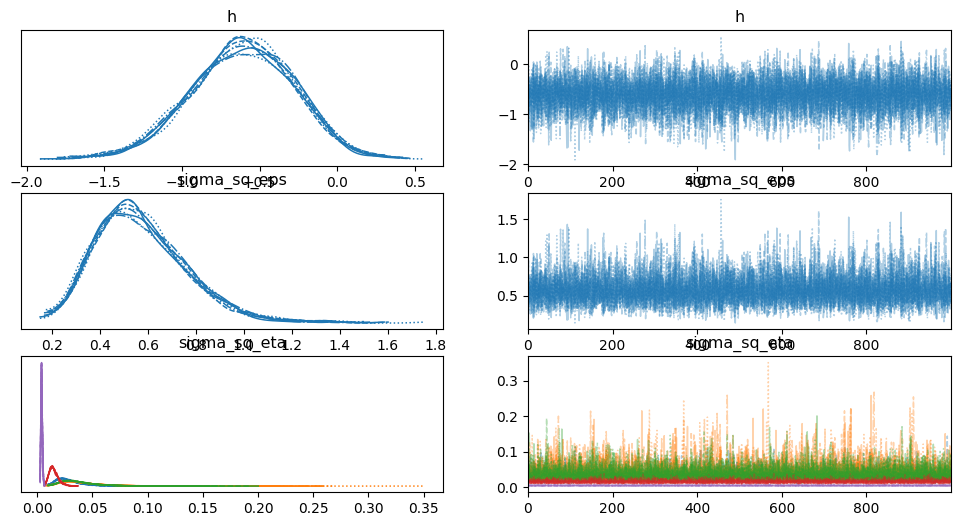

In [77]:
az.plot_trace(idata2016, var_names=['h', 'sigma_sq_eps', 'sigma_sq_eta'])
plt.show()

In [116]:
cond_post2016 = vkm2016.sample_conditional_posterior(idata2016)

/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x7F7ADF88E5E0>), RNG(<Generator(PCG64) at 0x7F7ADF88F5A0>), RNG(<Generator(PCG64) at 0x7F7ADF88EA40>), RNG(<Generator(PCG64) at 0x7F7ADF88F840>), RNG(<Generator(PCG64) at 0x7F7ADF88E420>), RNG(<Generator(PCG64) at 0x7F7A4AFE59A0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

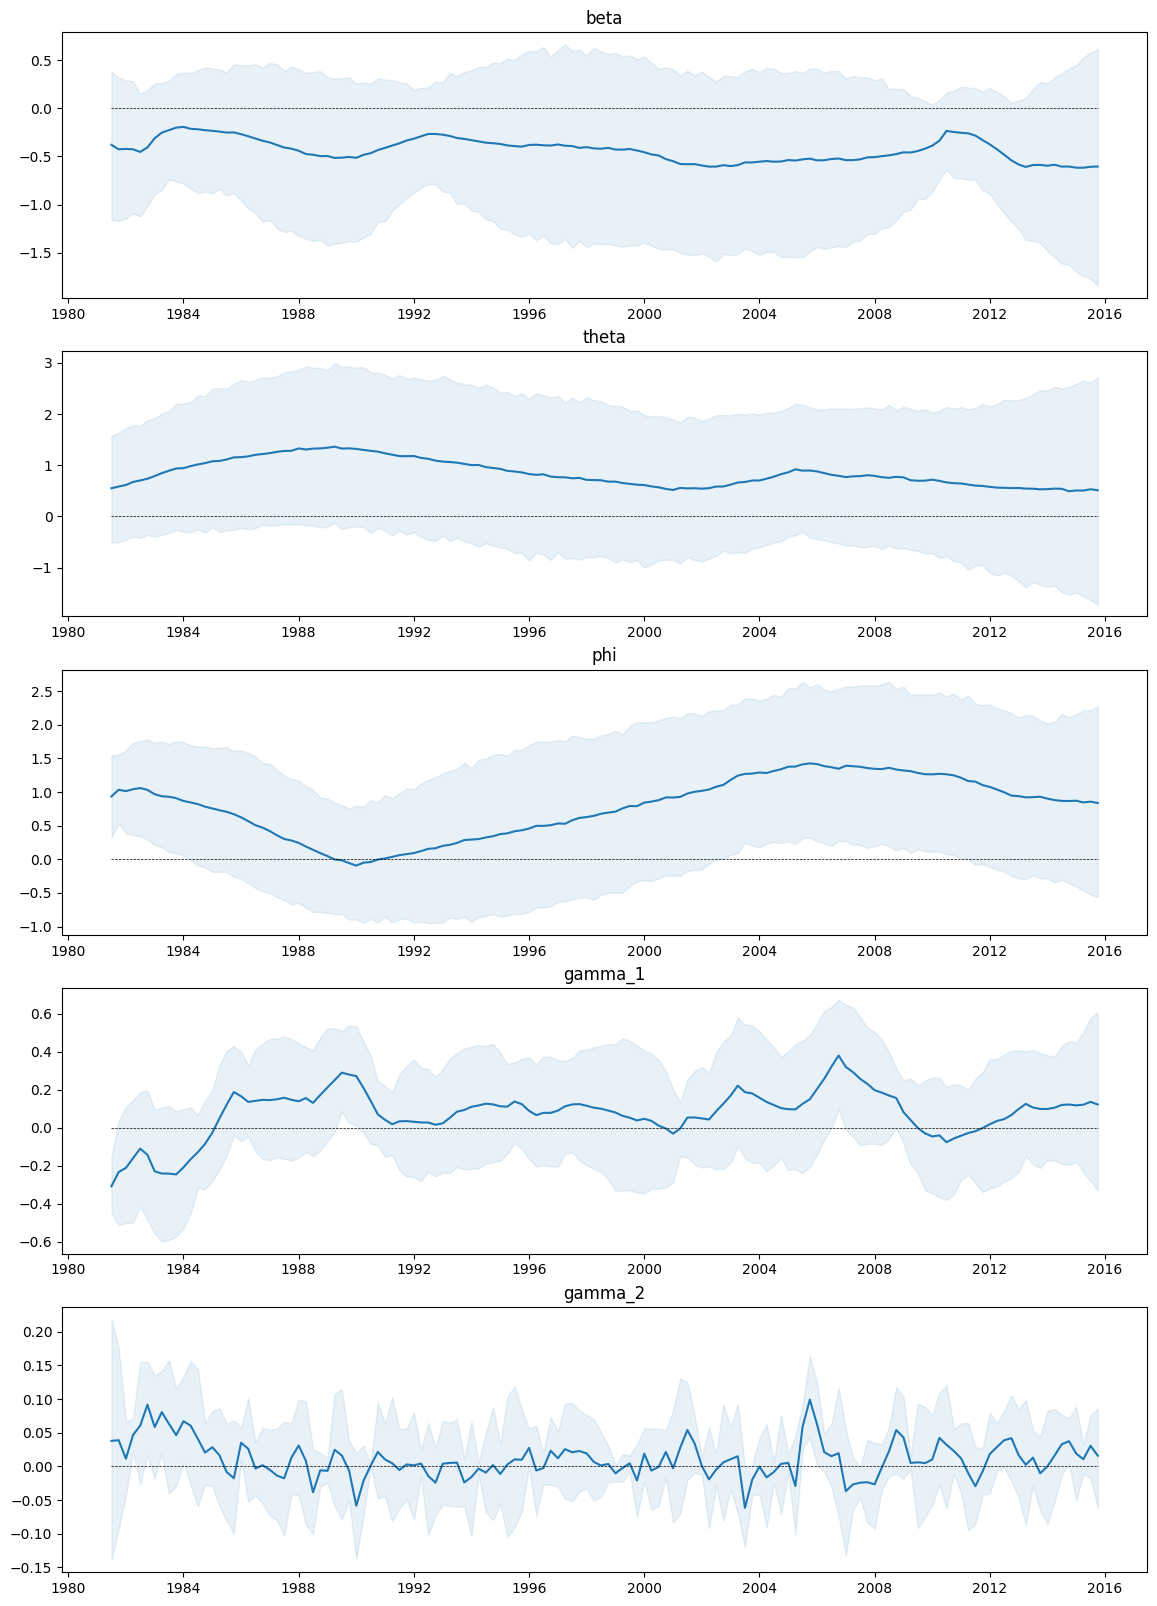

In [151]:
plot_latent_states(cond_post2016)

#### 1981-2025

In [82]:
vkm, idata = model_1(model_df, b_40, P_40)

The following parameters should be assigned priors inside a PyMC model block: 
	x0 -- shape: (5,), constraints: None, dims: ('state',)
	P0 -- shape: (5, 5), constraints: Positive Semi-definite, dims: ('state', 'state_aux')
	sigma_sq_eps -- shape: (1,), constraints: Positive, dims: ('observed_state',)
	sigma_sq_eta -- shape: (5,), constraints: Positive, dims: ('shock',)
The following Data variables should be assigned to the model inside a PyMC model block: 
	exog_data -- shape: (None, 5), dims: ('time', 'exog_data_dim')


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [83]:
az.summary(idata, var_names=['h', 'sigma_sq_eps', 'sigma_sq_eta'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
h                            0.143  0.210  -0.263    0.529      0.002   
sigma_sq_eps                 1.179  0.249   0.739    1.649      0.002   
sigma_sq_eta[beta_shock]     0.028  0.012   0.010    0.049      0.000   
sigma_sq_eta[theta_shock]    0.038  0.022   0.011    0.075      0.000   
sigma_sq_eta[phi_shock]      0.036  0.017   0.012    0.067      0.000   
sigma_sq_eta[gamma_1_shock]  0.014  0.004   0.008    0.020      0.000   
sigma_sq_eta[gamma_2_shock]  0.003  0.000   0.003    0.004      0.000   

                             mcse_sd  ess_bulk  ess_tail  r_hat  
h                              0.002   10412.0    6075.0    1.0  
sigma_sq_eps                   0.002   10412.0    6075.0    1.0  
sigma_sq_eta[beta_shock]       0.000   10172.0    5207.0    1.0  
sigma_sq_eta[theta_shock]      0.000    9545.0    5575.0    1.0  
sigma_sq_eta[phi_shock]        0.000   11939.0    6084.0    1.0  
sigma_sq_eta[gamma_1_shock]    0.000   10975.0    5977.0    1.0  
sigma_sq_eta[gamma_2_shock]    0.000   10756.0    6281.0    1.0

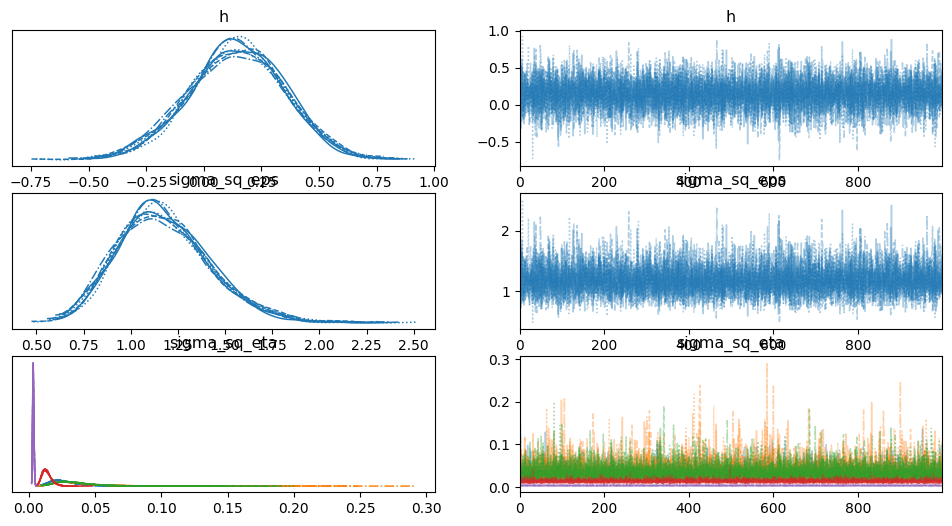

In [84]:
az.plot_trace(idata, var_names=['h', 'sigma_sq_eps', 'sigma_sq_eta'])
plt.show()

In [118]:
cond_post = vkm.sample_conditional_posterior(idata)

/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x7F7A801412A0>), RNG(<Generator(PCG64) at 0x7F7A801427A0>), RNG(<Generator(PCG64) at 0x7F7A80142500>), RNG(<Generator(PCG64) at 0x7F7A80142C00>), RNG(<Generator(PCG64) at 0x7F7A80142DC0>), RNG(<Generator(PCG64) at 0x7F7A4AF1E6C0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

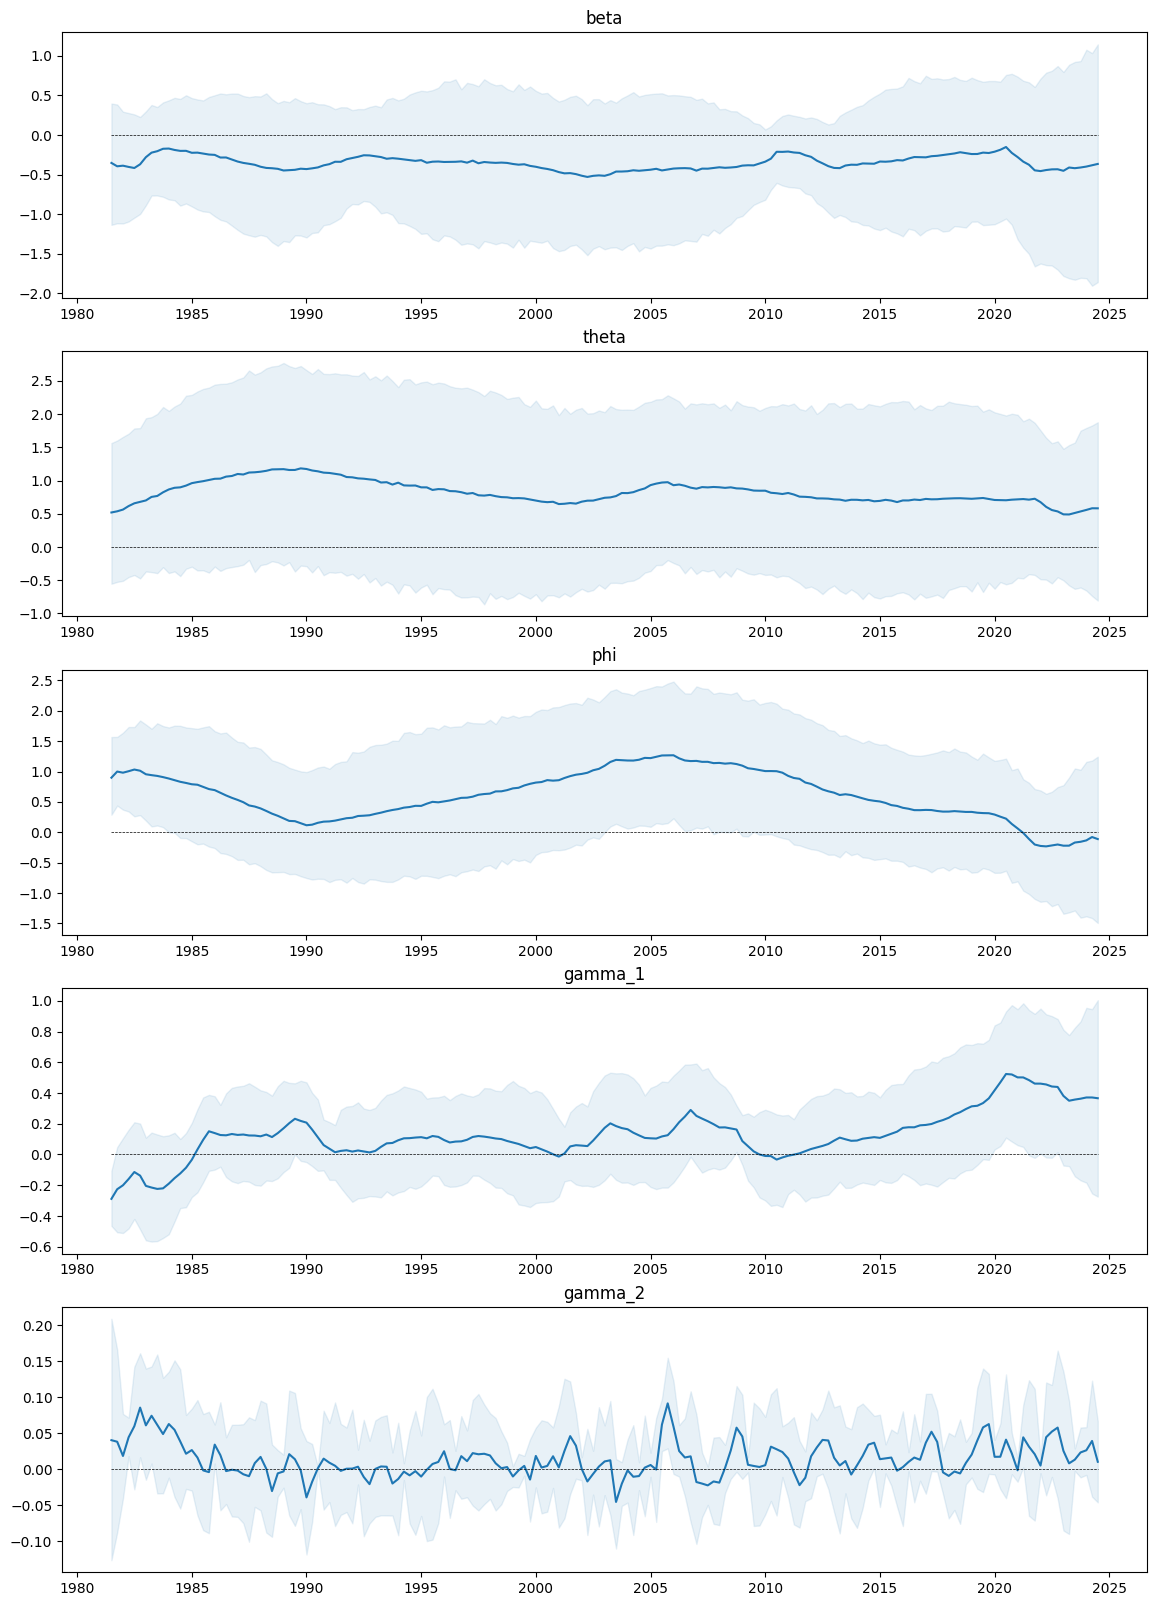

In [119]:
plot_latent_states(cond_post)

### Model Fit Using Weakly Informative Priors

#### 1981-2016

In [110]:
vkm2016_2, idata2016_2 = model_2(model2016_df)

The following parameters should be assigned priors inside a PyMC model block: 
	x0 -- shape: (5,), constraints: None, dims: ('state',)
	P0 -- shape: (5, 5), constraints: Positive Semi-definite, dims: ('state', 'state_aux')
	sigma_sq_eps -- shape: (1,), constraints: Positive, dims: ('observed_state',)
	sigma_sq_eta -- shape: (5,), constraints: Positive, dims: ('shock',)
The following Data variables should be assigned to the model inside a PyMC model block: 
	exog_data -- shape: (None, 5), dims: ('time', 'exog_data_dim')


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [111]:
az.summary(idata2016_2, var_names=['sigma_sq_eps', 'sigma_sq_eta'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
sigma_sq_eps                 0.985  0.238   0.544    1.413      0.003   
sigma_sq_eta[beta_shock]     0.041  0.036   0.000    0.105      0.000   
sigma_sq_eta[theta_shock]    0.160  0.181   0.000    0.484      0.002   
sigma_sq_eta[phi_shock]      0.180  0.115   0.020    0.389      0.001   
sigma_sq_eta[gamma_1_shock]  0.002  0.002   0.000    0.005      0.000   
sigma_sq_eta[gamma_2_shock]  0.000  0.000   0.000    0.000      0.000   

                             mcse_sd  ess_bulk  ess_tail  r_hat  
sigma_sq_eps                   0.002    6533.0    5443.0    1.0  
sigma_sq_eta[beta_shock]       0.000    6060.0    3943.0    1.0  
sigma_sq_eta[theta_shock]      0.002    7055.0    3922.0    1.0  
sigma_sq_eta[phi_shock]        0.001    6480.0    5893.0    1.0  
sigma_sq_eta[gamma_1_shock]    0.000    5969.0    3690.0    1.0  
sigma_sq_eta[gamma_2_shock]    0.000    7441.0    5593.0    1.0

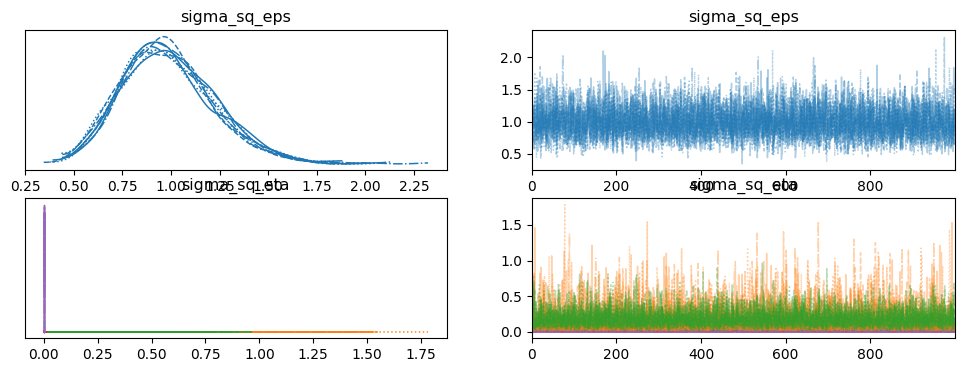

In [112]:
az.plot_trace(idata2016_2, var_names=['sigma_sq_eps', 'sigma_sq_eta'])
plt.show()

In [120]:
cond_post2016_2 = vkm2016_2.sample_conditional_posterior(idata2016_2)

/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x7F7AA02811C0>), RNG(<Generator(PCG64) at 0x7F7AA0281D20>), RNG(<Generator(PCG64) at 0x7F7AA0281C40>), RNG(<Generator(PCG64) at 0x7F7AA0281380>), RNG(<Generator(PCG64) at 0x7F7AA0280740>), RNG(<Generator(PCG64) at 0x7F7A68465FC0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

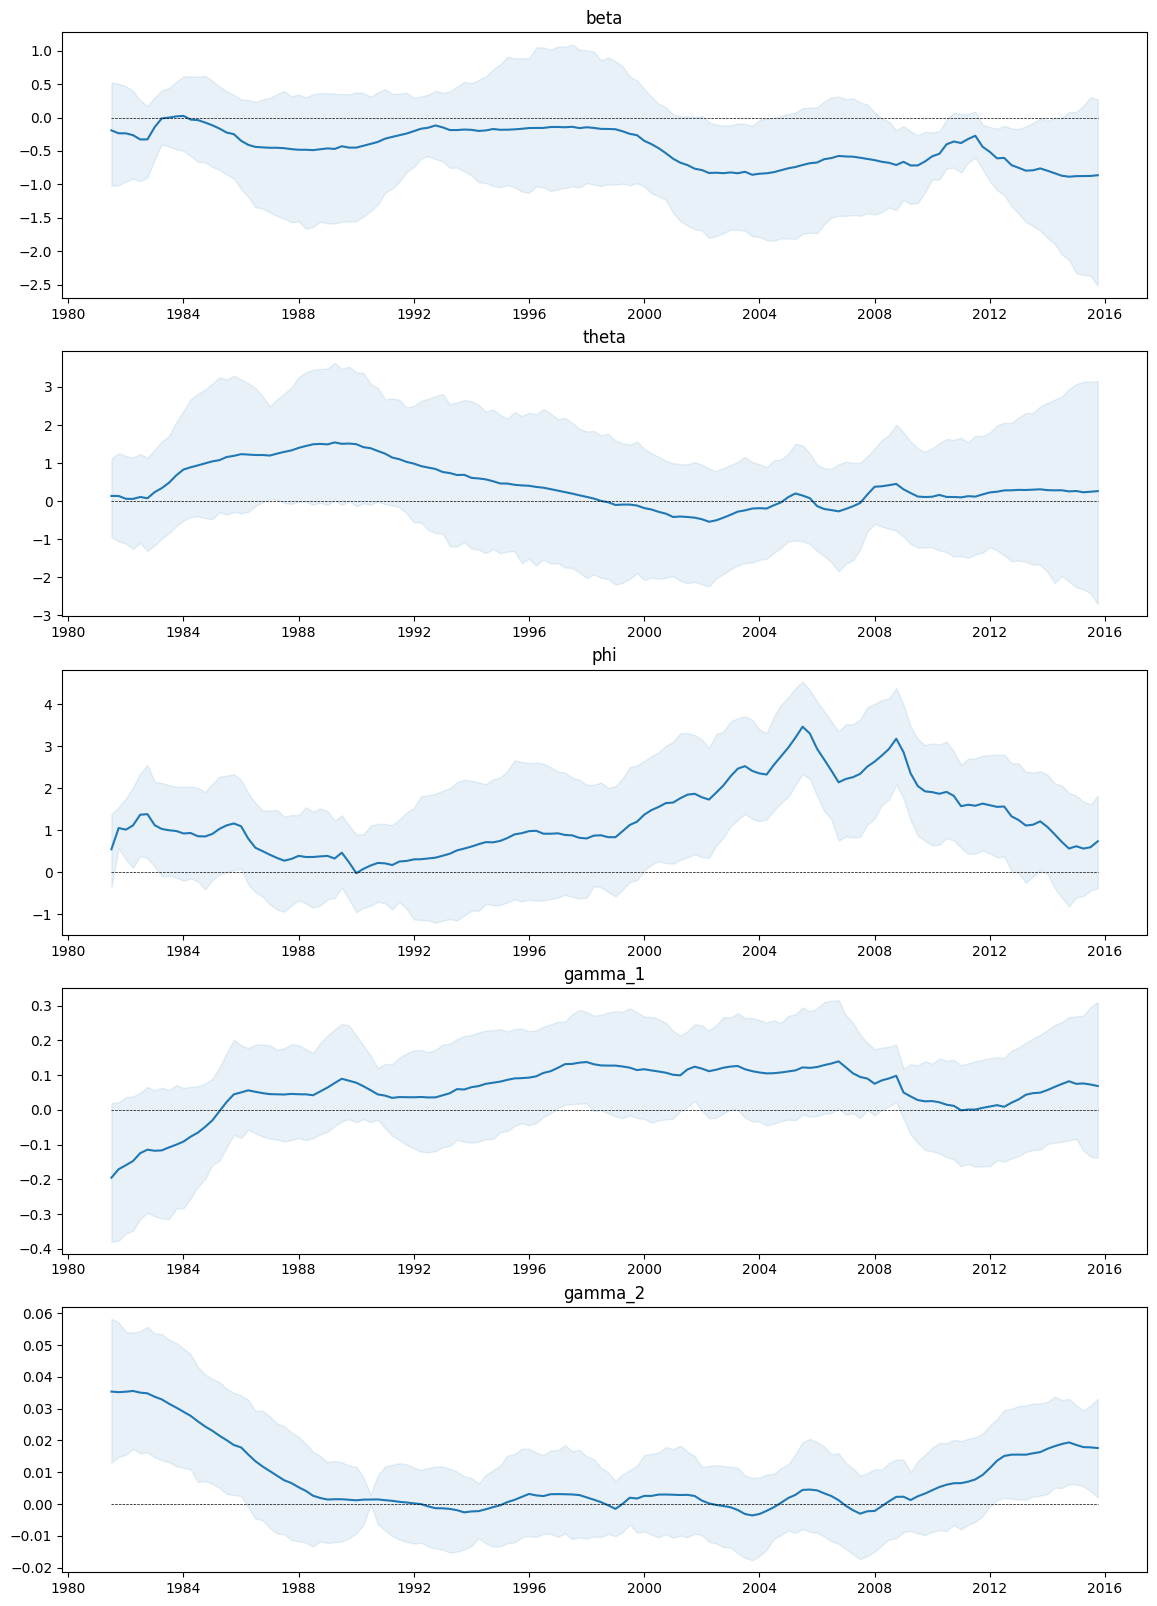

In [121]:
plot_latent_states(cond_post2016_2)

#### 1981-2025

In [99]:
vkm_2, idata_2 = model_2(model_df)

The following parameters should be assigned priors inside a PyMC model block: 
	x0 -- shape: (5,), constraints: None, dims: ('state',)
	P0 -- shape: (5, 5), constraints: Positive Semi-definite, dims: ('state', 'state_aux')
	sigma_sq_eps -- shape: (1,), constraints: Positive, dims: ('observed_state',)
	sigma_sq_eta -- shape: (5,), constraints: Positive, dims: ('shock',)
The following Data variables should be assigned to the model inside a PyMC model block: 
	exog_data -- shape: (None, 5), dims: ('time', 'exog_data_dim')


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [100]:
az.summary(idata_2, var_names=['sigma_sq_eps', 'sigma_sq_eta'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
sigma_sq_eps                 1.551  0.265   1.062    2.042      0.003   
sigma_sq_eta[beta_shock]     0.017  0.022   0.000    0.055      0.000   
sigma_sq_eta[theta_shock]    0.072  0.103   0.000    0.245      0.001   
sigma_sq_eta[phi_shock]      0.104  0.078   0.009    0.245      0.001   
sigma_sq_eta[gamma_1_shock]  0.002  0.002   0.000    0.005      0.000   
sigma_sq_eta[gamma_2_shock]  0.000  0.000   0.000    0.000      0.000   

                             mcse_sd  ess_bulk  ess_tail  r_hat  
sigma_sq_eps                   0.002    7898.0    5643.0    1.0  
sigma_sq_eta[beta_shock]       0.000    7684.0    4964.0    1.0  
sigma_sq_eta[theta_shock]      0.001    7634.0    4029.0    1.0  
sigma_sq_eta[phi_shock]        0.001    8081.0    5851.0    1.0  
sigma_sq_eta[gamma_1_shock]    0.000    9502.0    5256.0    1.0  
sigma_sq_eta[gamma_2_shock]    0.000   10306.0    4894.0    1.0

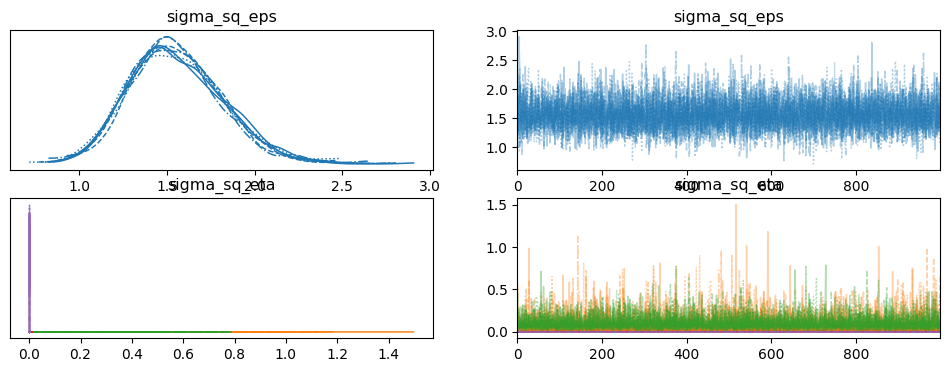

In [101]:
az.plot_trace(idata_2, var_names=['sigma_sq_eps', 'sigma_sq_eta'])
plt.show()

In [122]:
cond_post_2 = vkm_2.sample_conditional_posterior(idata_2)

/home/rebane/miniconda3/envs/py312/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x7F7A687265E0>), RNG(<Generator(PCG64) at 0x7F7A687266C0>), RNG(<Generator(PCG64) at 0x7F7A68727CA0>), RNG(<Generator(PCG64) at 0x7F7A68727BC0>), RNG(<Generator(PCG64) at 0x7F7A68726DC0>), RNG(<Generator(PCG64) at 0x7F7A803BE5E0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

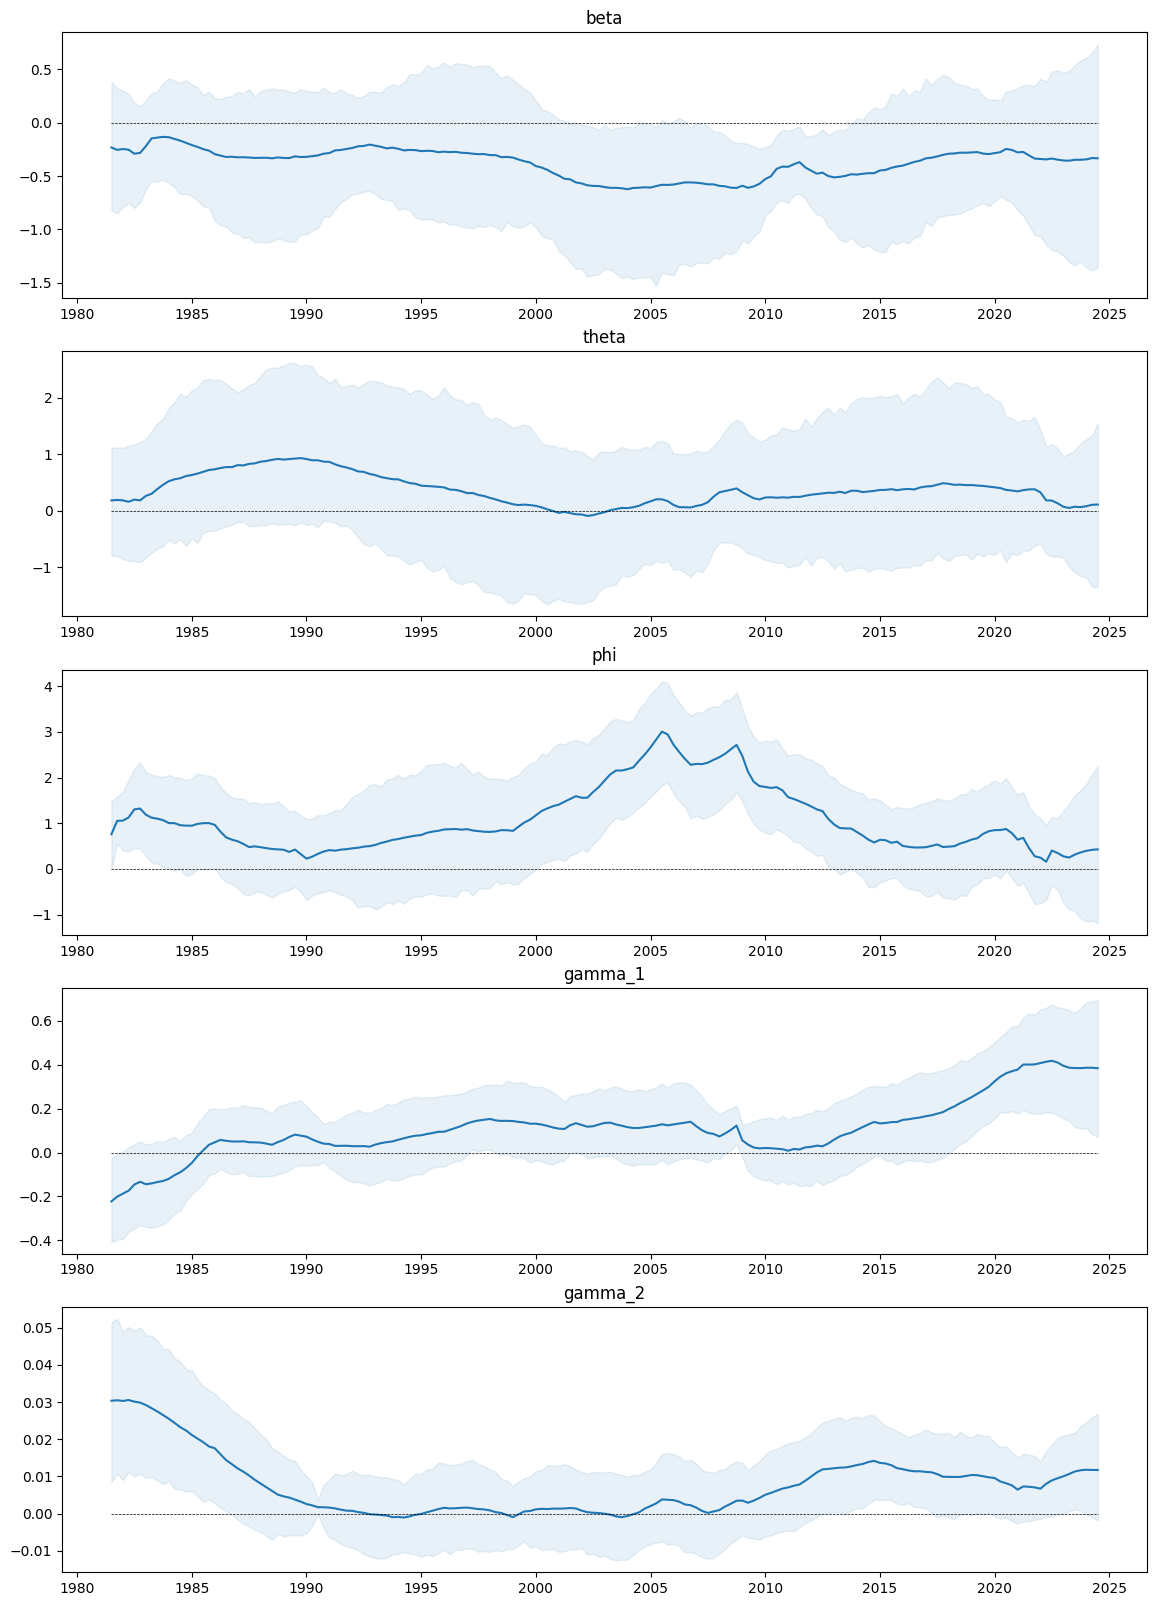

In [123]:
plot_latent_states(cond_post_2)

### Figure 4.3 a

#### Stricter priors

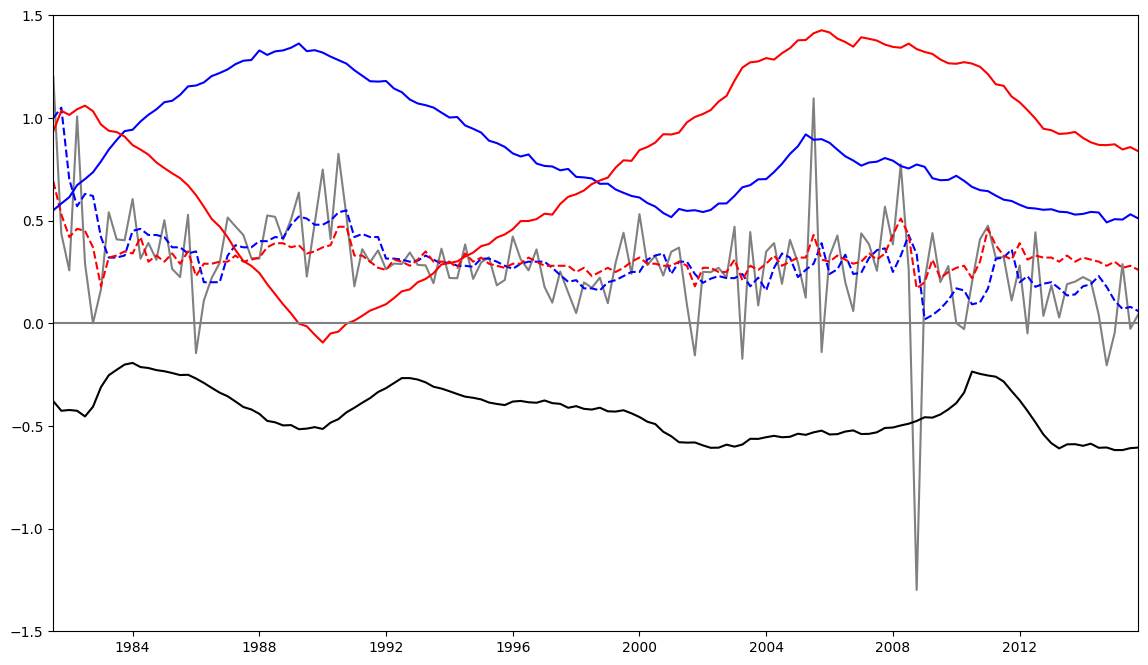

In [150]:
figure_4_3_a(model2016_df, cond_post2016)

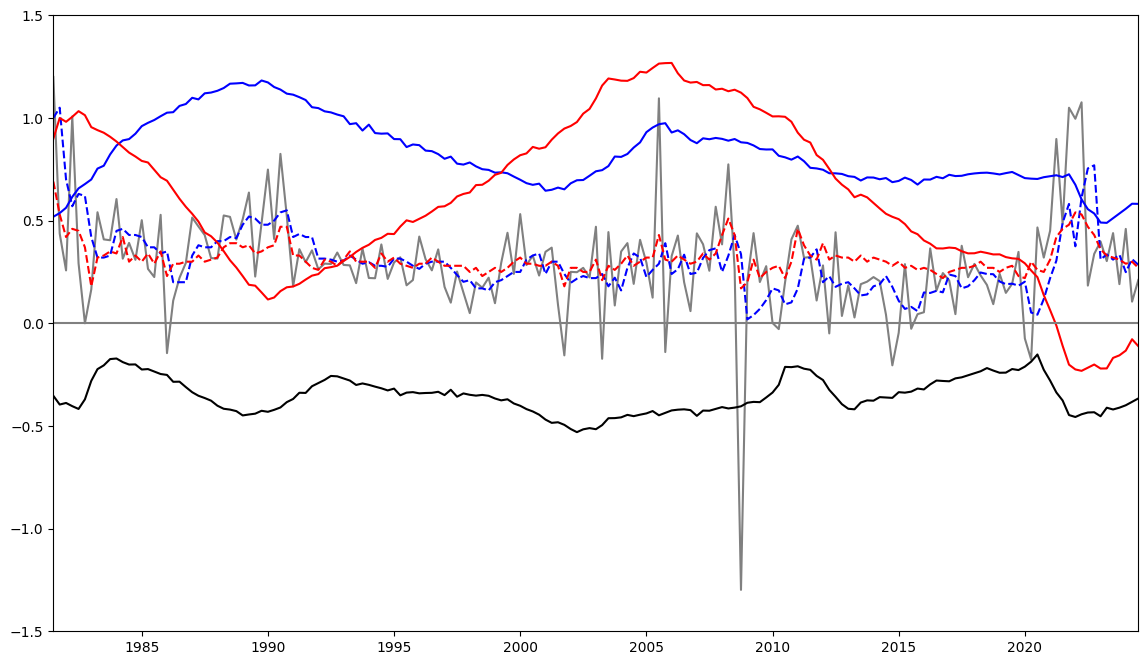

In [125]:
figure_4_3_a(model_df, cond_post)

#### Weakly informative priors

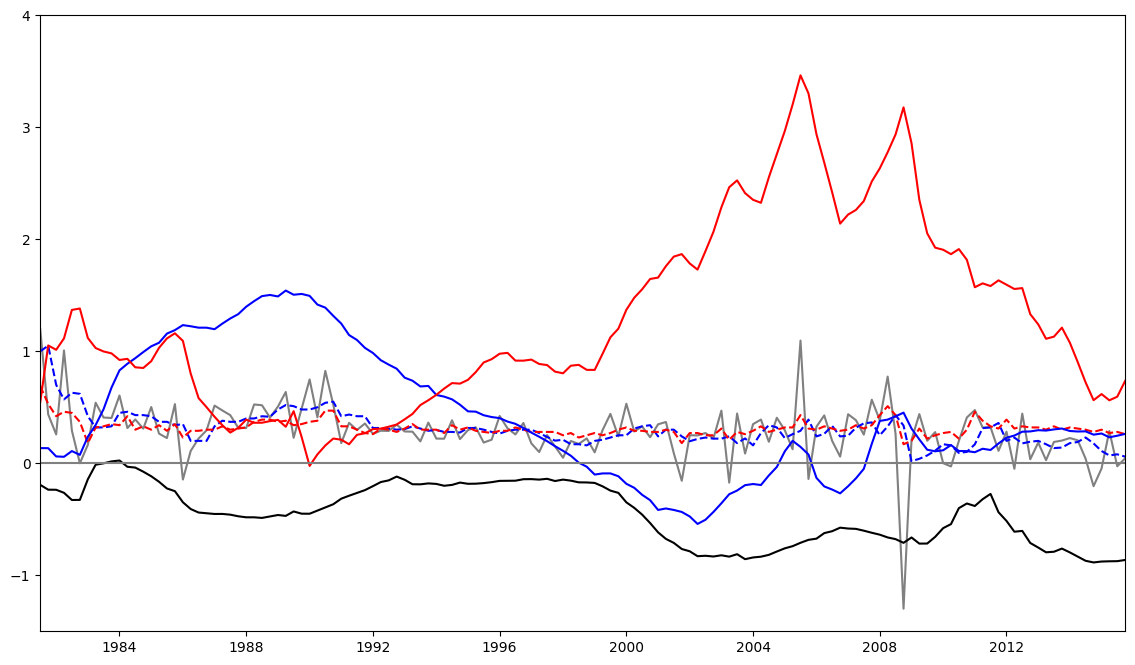

In [147]:
figure_4_3_a(model2016_df, cond_post2016_2, ylim=(-1.5, 4.0))

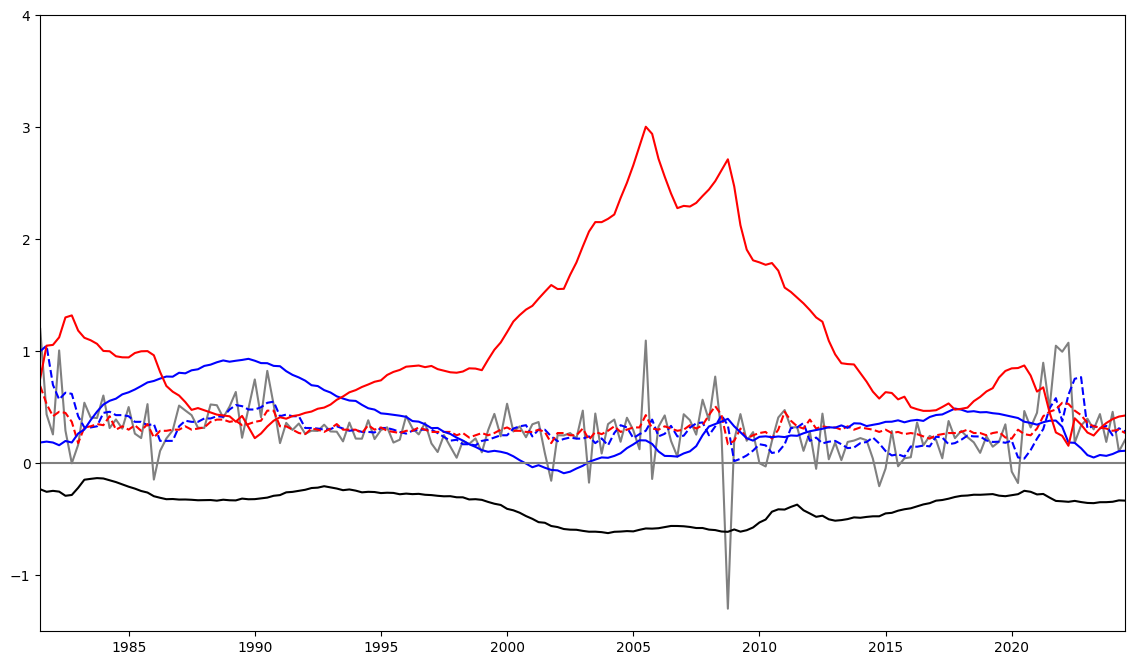

In [149]:
figure_4_3_a(model_df, cond_post_2, ylim=(-1.5, 4.0))